## Custom models

To score your model, simply wrap it in one of the available wrappers (PyTorch, TensorFlow or Keras) and pass it to a scoring method.

### PyTorch

Let's define a simple convolution-relu-linear-relu model.

In [1]:
import numpy as np
import torch
from torch import nn

from candidate_models.models.implementations.pytorch import PytorchModel


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3)
        self.relu1 = torch.nn.ReLU()
        linear_input_size = np.power((224 - 3 + 2 * 0) / 1 + 1, 2) * 2
        self.linear = torch.nn.Linear(int(linear_input_size), 1000)
        self.relu2 = torch.nn.ReLU()  # can't get named ReLU output otherwise

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.relu2(x)
        return x


caching


Using TensorFlow backend.


cornet_s already in models (<function cornet_s at 0x7f8758da5400> - overwriting


caching


Next, wrap the model in the PyTorch wrapper.

In [2]:
from candidate_models.models.implementations.pytorch import PytorchModel


class MyModelWrapper(PytorchModel):
    def __init__(self, *args, **kwargs):
        super().__init__('mymodel', *args, **kwargs)

    def _create_model(self, weights):
        my_model = MyModel()
        assert weights is None  # weight loading would go here
        return my_model

Finally, pass the model to the scoring method and pass an identifier (for caching results).

In [3]:
from candidate_models import score_model

score = score_model(model_identifier='test_pytorch', model=MyModelWrapper, 
                    layers=['linear', 'relu2'], weights=None, pca_components=None)
print(score.aggregation)

<xarray.DataAssembly (aggregation: 2, region: 2, layer: 2)>
array([[[0.154412, 0.192535],
        [0.25282 , 0.281037]],

       [[0.004922, 0.005747],
        [0.006881, 0.006893]]])
Coordinates:
  * aggregation  (aggregation) object 'center' 'error'
  * layer        (layer) object 'linear' 'relu2'
  * region       (region) object 'IT' 'V4'


The aggregated score holds scores across layers and regions (for an explanation of what the score entails, see [brain-score/examples/metrics.ipynb](https://github.com/dicarlolab/brain-score/blob/master/examples/metrics.ipynb)).

### TensorFlow Slim

Let's define a simple model with a convolution and pooling.

In [2]:
import tensorflow as tf
slim = tf.contrib.slim


def _create_tf_model(inputs):
    with tf.variable_scope('my_model', values=[inputs]) as sc:
        end_points_collection = sc.original_name_scope + '_end_points'
        # Collect outputs for conv2d, fully_connected and max_pool2d.
        with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.max_pool2d],
                            outputs_collections=[end_points_collection]):
            net = slim.conv2d(inputs, 64, [11, 11], 4, padding='VALID', scope='conv1')
            net = slim.max_pool2d(net, [5, 5], 5, scope='pool1')
            net = slim.max_pool2d(net, [3, 3], 2, scope='pool2')
            end_points = slim.utils.convert_collection_to_dict(end_points_collection)
            return net, end_points

Next, wrap the model in the TensorFlow wrapper.

In [3]:
from candidate_models.models.implementations.tensorflow_slim import TensorflowSlimModel
# requires you to have TF slim installed: https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim
from preprocessing import vgg_preprocessing


class MyModelWrapper(TensorflowSlimModel):
    def _create_inputs(self, batch_size, image_size):
        inputs = tf.placeholder(dtype=tf.float32, shape=[batch_size, image_size, image_size, 3])
        preprocess_image = vgg_preprocessing.preprocess_image
        return tf.map_fn(lambda image: preprocess_image(tf.image.convert_image_dtype(image, dtype=tf.uint8),
                                                        image_size, image_size), inputs)

    def _create_model(self, inputs):
        return _create_tf_model(inputs)

    def _restore(self, weights):
        assert weights is None
        init = tf.initialize_all_variables()
        self._sess.run(init)


Finally, pass the model to the scoring method and pass an identifier (for caching results).

In [4]:
from candidate_models import score_model

score = score_model(model_identifier='test_tensorflow_slim', model=MyModelWrapper, 
                    layers=['my_model/pool2'], weights=None, pca_components=None)
print(score.aggregation.sel(aggregation='center'))

<xarray.DataAssembly (region: 2, layer: 1)>
array([[0.403759],
       [0.435773]])
Coordinates:
    aggregation  <U6 'center'
  * region       (region) object 'IT' 'V4'
  * layer        (layer) <U14 'my_model/pool2'


The aggregated score holds scores across layers and regions (for an explanation of what the score entails, see below).

## Pre-defined models

### Single model

Scoring a model on neural data can be done in a single line using the `score_physiology` method.
This call is agnostic of a specific model implementation, it will simply look up the model name 
in `neurality.models.models` and use the implementation defined there (also see `examples/model-activations.ipynb`).
By default, the pre-defined layers of a model will be used to retrieve the activations, 
but you can also pass your own.
Just like with the model implementations, the result of this method call will be cached 
so that it only needs to be computed once.


In [2]:
from candidate_models import score_model

score = score_model(model='alexnet', benchmark='dicarlo.Majaj2015')
print(score)


Score(values=<xarray.DataAssembly (region: 2, layer: 7, split: 10, neuroid_id: 256)>
array([[[[0.368529, ...,      nan],
         ...,
         [0.361907, ...,      nan]],

        ...,

        [[0.345111, ...,      nan],
         ...,
         [0.310121, ...,      nan]]],


       [[[     nan, ..., 0.375341],
         ...,
         [     nan, ..., 0.401544]],

        ...,

        [[     nan, ..., 0.515537],
         ...,
         [     nan, ..., 0.475535]]]])
Coordinates:
  * layer       (layer) object 'classifier.2' 'classifier.5' 'features.12' ...
  * neuroid_id  (neuroid_id) object 'Chabo_L_A_2_4' 'Chabo_L_A_3_3' ...
  * region      (region) object 'IT' 'V4'
  * split       (split) int64 0 1 2 3 4 5 6 7 8 9,aggregation=<xarray.DataAssembly (aggregation: 2, region: 2, layer: 7)>
array([[[0.559135, 0.514513, 0.588901, 0.376877, 0.512878, 0.537404,
         0.548965],
        [0.425916, 0.34737 , 0.486357, 0.625188, 0.63075 , 0.626955,
         0.574051]],

       [[0.003256, 0.002

The resulting score object now contains two fields: `aggregation` and `values`.

`values` are the raw scores across cross-validations and neuroids.
The `aggregation` combines these raw `values` into "center" (mean in this case) and "error" (standard-error-of-the-mean in this case).
In the default case, there will be one score for each combination of layers and brain regions.

Since each sub-score (aggregation and values) is an xarray again, we can easily filter:

In [5]:
center = score.aggregation.sel(aggregation='center')
print("center\n", center)

center
 <xarray.DataAssembly (region: 2, layer: 7)>
array([[0.559135, 0.514513, 0.588901, 0.376877, 0.512878, 0.537404, 0.548965],
       [0.425916, 0.34737 , 0.486357, 0.625188, 0.63075 , 0.626955, 0.574051]])
Coordinates:
    aggregation  <U6 'center'
  * layer        (layer) object 'classifier.2' 'classifier.5' 'features.12' ...
  * region       (region) object 'IT' 'V4'


In the Brain-Score paper, we reported the maximum score across layers, i.e.:

In [6]:
print("\nlayer max\n", center.max('layer'))


layer max
 <xarray.DataAssembly (region: 2)>
array([0.588901, 0.63075 ])
Coordinates:
    aggregation  <U6 'center'
  * region       (region) object 'IT' 'V4'


### Many models

Text(0,0.5,'Neural Predictivity')

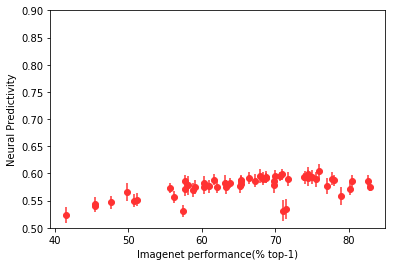

In [19]:
from collections import OrderedDict
%matplotlib inline

# The power of this framework partly stems from the ability to quickly score many models.
# In the following, we will reproduce Figure 2 from the paper for IT.
from matplotlib import pyplot
from neurality import score_physiology
from neurality.models import models_meta

models_performance = {row['model']: row['top1'] * 100 for _, row in models_meta.iterrows() if not row['model'].startswith('basenet')
                      # the TF Slim implementation of ResNets v1 is potentially erroneous, so we exclude them
                      and row['model'] not in ['resnet-50_v1', 'resnet-101_v1', 'resnet-101_v2', 'resnet-152_v1']}
model_it_score_means, model_it_score_errs = OrderedDict(), OrderedDict()
for model in models_performance:
    # score the model
    score = score_physiology(model=model, neural_data='dicarlo.Majaj2015')
    # ignore V4, only plot the IT score
    it_score = score.center.sel(region='IT')
    # use the best layer's score as the model's score
    max_score = it_score.max('layer')
    max_layer = it_score.where(it_score == max_score, drop=True)['layer']
    model_it_score_means[model] = max_score
    model_it_score_errs[model] = score.error.sel(region='IT', layer=max_layer)
# plot
x, y, err = list(models_performance.values()), list(model_it_score_means.values()), list(model_it_score_errs.values())
pyplot.scatter(x, y, color='#ff3232')
pyplot.errorbar(x, y, yerr=err, color='#ff3232', linestyle='None')
pyplot.ylim([.5, .9])
pyplot.xlabel('Imagenet performance(% top-1)')
pyplot.ylabel('Neural Predictivity')
